In [1]:
from integsol.mesh.mesh import Mesh
from integsol.compute.vectors import VectorField
from integsol.compute.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.validators.compute_validators import *
from integsol.compute.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")
#mesh_2 = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 98.21%

Calculate measures for tri type of elements
Progress: 99.75%

Calculate measures for tet type of elements
Progress: 99.95%

Calculation of measures of all elements finished in 9.511087656021118 seconds.


In [4]:
centers = mesh.elements_centers['tet'].T
nodes = mesh.coordinates.T

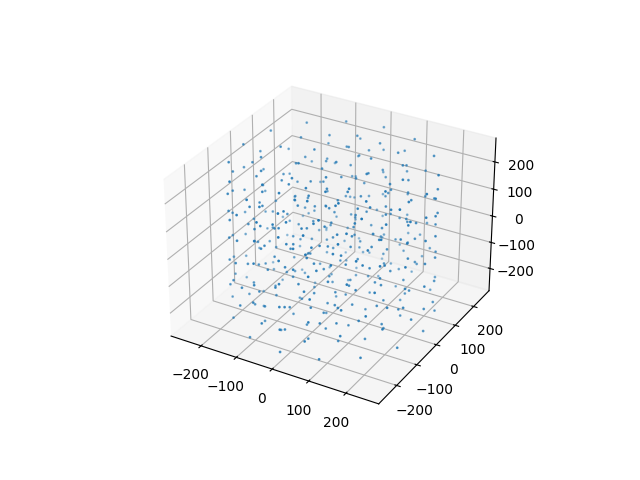

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(nodes[0]), ys=np.float64(nodes[1]), zs=np.float64(nodes[2]), s=1)
#ax.scatter(xs=mesh.coordinates[Hd_nodes_nans][0], ys=mesh.coordinates[Hd_nodes_nans][1], zs=mesh.coordinates[Hd_nodes_nans][2], color='red')

In [7]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [6]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/magnetization_coerser.txt",
    mesh=mesh,
    dim=3)


_M0 = M0.vectorize()

In [7]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_

Begin placement of operator on mesh elements' centers.
Progress: 99.95%

Mesh matric of the operator generated in 2.808753728866577 seconds.


tensor([[ 0.0000e+00, -1.0000e+00,  9.5869e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00, -1.3177e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.5869e-05,  1.3177e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
         -1.0000e+00, -4.7344e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
         -0.0000e+00,  6.2193e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.7344e-05,
         -6.2193e-05,  0.0000e+00]])

In [8]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.95%

Mesh matric of the operator generated in 167.5814254283905 seconds.


In [9]:
Hd = VectorField(mesh=mesh, coordinates=mesh.elements_centers['tet'])

_Hd = mv(int_G_, _M0)
Hd.devectorize(_Hd)
_Hd[0].tolist()

-4.8329412903062

In [10]:
H0 = VectorField(
    mesh=mesh,
    coordinates=mesh.elements_centers['tet'],
    values=np.array([[0,0,5e5 / M_s] for _ in range(len(mesh.elements_centers['tet']))])
)
_H0 = H0.vectorize()
_H0

_vals_H_eff = M_s * np.array(H0.values + Hd.values).T

In [11]:
H_eff = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/H_demag.txt",
    mesh=mesh,
    dim=3)

_H_eff = H_eff.vectorize()
vals_H_eff = H_eff.values.T

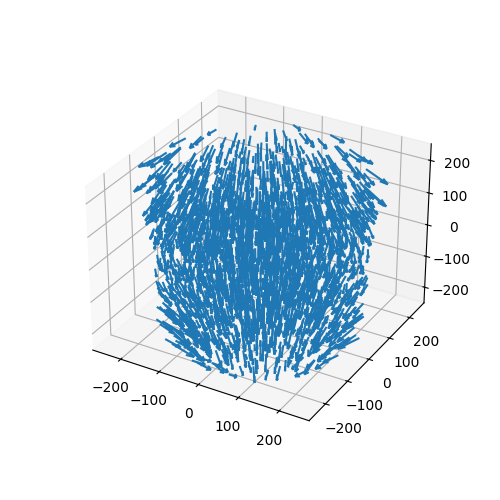

In [12]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    vals_H_eff[0],
    vals_H_eff[1],
    vals_H_eff[2],
    length=0.001,
)

plt.show()

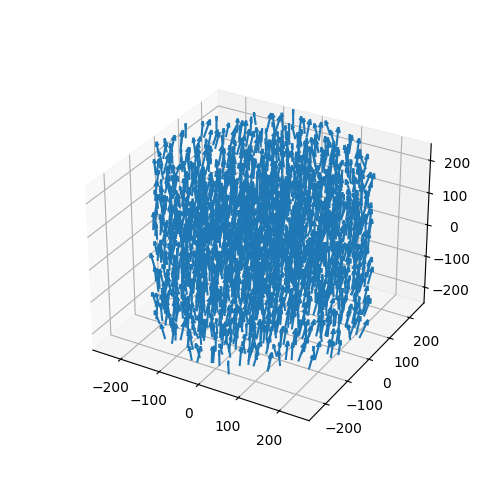

In [13]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    _vals_H_eff[0],
    _vals_H_eff[1],
    _vals_H_eff[2],
    length=0.0001,
)

plt.show()

In [ ]:
H_demg = VectorField(dim=3, coordinates=mesh.coordinates, mesh=mesh)

In [ ]:
np.zeros(shape=(6,3))